# Statement

A companhia de seguros Proteja Seu Amanhã quer resolver algumas tarefas com a ajuda de aprendizado de máquina e você precisa avaliar a possibilidade de fazê-lo.

- Tarefa 1: Encontrar clientes semelhantes a um determinado cliente. Isso vai ajudar os agentes da empresa com tarefas de marketing.
- Tarefa 2: Predizer se um novo cliente provavelmente receberá um pagamento de seguro. Um modelo de predição pode ser melhor do que um modelo dummy?
- Tarefa 3: Predizer o número de pagamentos de seguro que um novo cliente provavelmente receberá usando um modelo de regressão linear.
- Tarefa 4: Proteger os dados pessoais dos clientes sem estragar o modelo da tarefa anterior. É necessário desenvolver um algoritmo de transformação de dados que tornaria difícil recuperar informações pessoais se os dados caíssem nas mãos erradas. Isso é chamado de mascaramento de dados ou ofuscação de dados. Mas os dados devem ser protegidos de forma que a qualidade dos modelos de aprendizado de máquina não piore. Você não precisa escolher o melhor modelo, só prove que o algoritmo funciona corretamente.

# Pré-processamento de dados & Exploração

## Inicialização

In [1]:
import numpy as np
import pandas as pd
import math

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split

from IPython.display import display

## Carregar Dados

Carregue os dados e faça uma verificação básica de que estão livres de problemas óbvios.

In [2]:
df = pd.read_csv('datasets/insurance_us.csv')

Renomeamos as colunas para tornar o código mais consistente com seu estilo.

In [3]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [4]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
337,0,20.0,44900.0,2,0
527,0,21.0,47900.0,1,0
4283,0,35.0,42400.0,1,0
4343,1,39.0,32100.0,0,0
4818,1,34.0,35100.0,1,0
94,0,32.0,33300.0,0,0
4854,1,22.0,30300.0,1,0
167,1,35.0,44900.0,2,0
3059,0,18.0,33400.0,2,0
3200,0,33.0,41000.0,1,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
# podemos querer corrigir o tipo de idade (de float para int), embora isso não seja crítico

# escreva sua conversão aqui se você escolher:
df['age'] = df['age'].astype(int)

In [7]:
# verifique se a conversão foi bem-sucedida
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [8]:
# agora dê uma olhada nas estatísticas descritivas dos dados.
# Parece que está tudo bem?
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Parece estar tudo em ordem.

## AED

Vamos verificar rapidamente se existem determinados grupos de clientes observando o gráfico de pares.

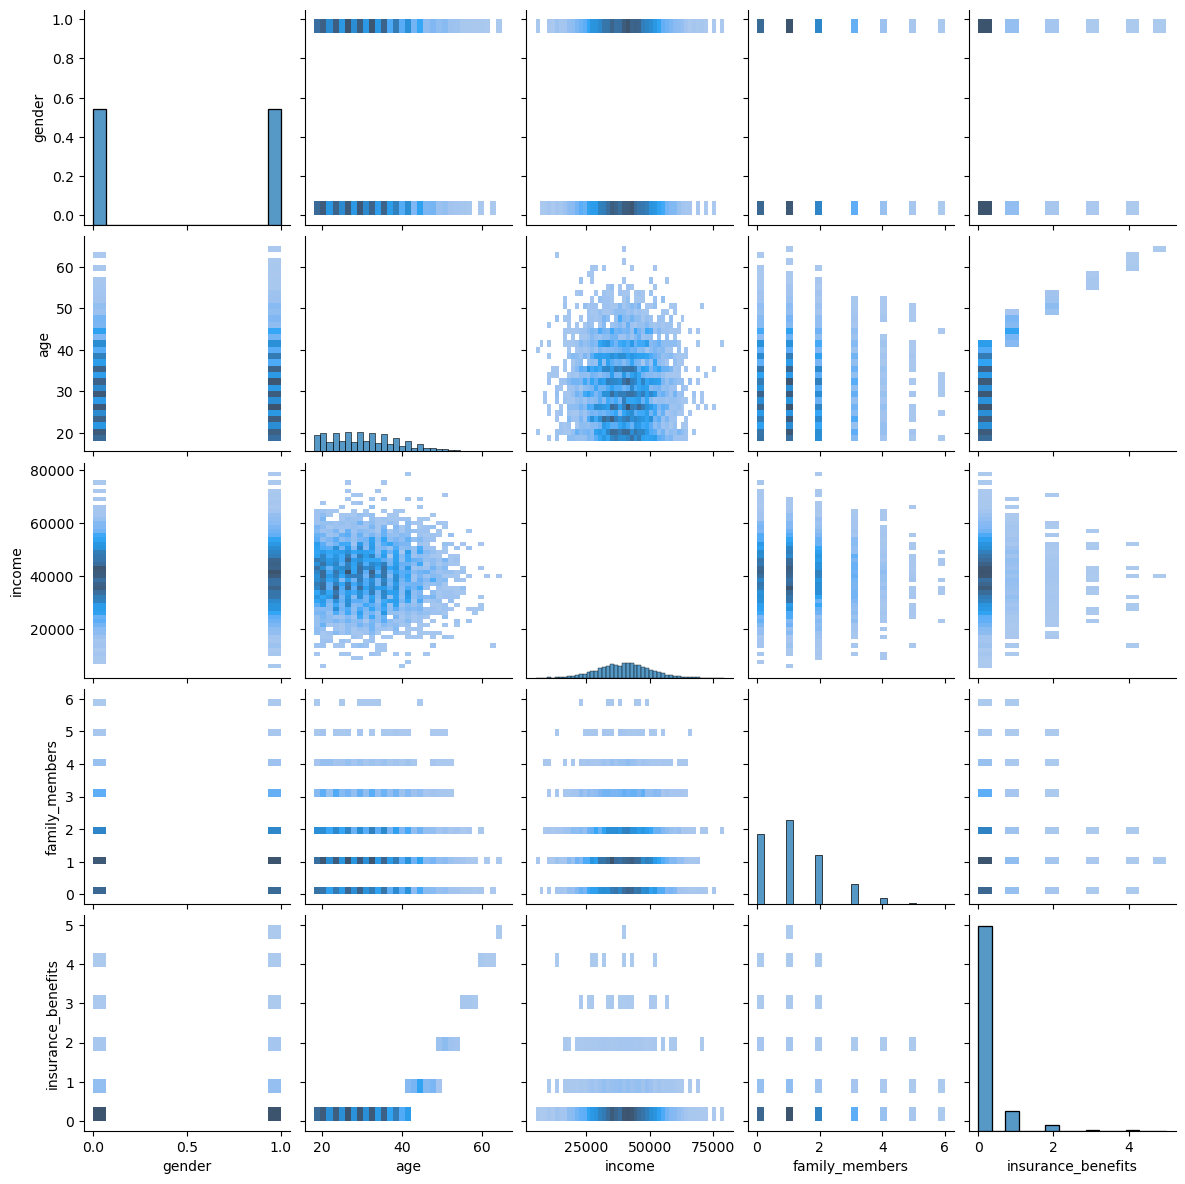

In [9]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, é um pouco difícil identificar grupos óbvios (clusters), pois é difícil combinar várias variáveis simultaneamente (para analisar distribuições multivariadas). É aí que Álgebra Linear e Aprendizado de Máquina podem ser bastante úteis.

# Tarefa 1. Clientes Similares

Na linguagem de AM, é necessário desenvolver um procedimento que retorne k vizinhos mais próximos (objetos) para um determinado objeto com base na distância entre os objetos.

Você pode querer rever as seguintes lições (capítulo -> lição)
- Distância Entre Vetores -> Distância Euclidiana
- Distância Entre Vetores -> Distância de Manhattan

Para resolver a tarefa, podemos tentar diferentes métricas de distância.

Escreva uma função que retorne k vizinhos mais próximos para um n-ésimo objeto com base em uma métrica de distância especificada. O número de pagamentos de seguro recebidos não deve ser levado em consideração para esta tarefa. 

Você pode usar uma implementação pronta do algoritmo kNN do scikit-learn (verifique [o link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) ou usar a sua própria.

Teste-o para quatro combinações de dois casos
- Escalabilidade
  - os dados não são escalados
  - os dados escalados com o escalonador [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) 
- Métricas de distância
  - Euclidiana
  - Manhattan

Responda às perguntas:
- Os dados não escalados afetam o algoritmo kNN? Se sim, como isso acontece?
-Quão semelhantes são os resultados usando a métrica de distância de Manhattan (independentemente da escalabilidade)?

In [10]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [11]:
def get_knn(df, n, k, metric):
    
    """
    Retorna os vizinhos mais próximos de k

    :param df: DataFrame pandas usado para encontrar objetos semelhantes dentro de
    :param n: número do objeto pelo qual os vizinhos mais próximos são procurados
    :param k: o número dos vizinhos mais próximos a serem retornados
    :param metric: nome da métrica de distância
    """

    nbrs = sklearn.neighbors.NearestNeighbors(metric=metric).fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Escalando os dados

In [12]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

C:\Users\joaod\AppData\Local\Temp\ipykernel_22488\760832288.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.63076923 0.70769231 0.44615385 ... 0.30769231 0.33846154 0.43076923]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())
C:\Users\joaod\AppData\Local\Temp\ipykernel_22488\760832288.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.16666667 0.16666667 0.         ... 0.33333333 0.5        0.16666667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())


In [13]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
3297,0,0.369231,0.440506,0.000000,0
27,1,0.461538,0.440506,0.166667,0
2702,0,0.384615,0.451899,0.000000,0
2219,1,0.323077,0.497468,0.166667,0
241,1,0.415385,0.410127,0.166667,0


Agora, vamos obter registros semelhantes para um determinado registro para cada combinação

In [14]:
n = 0
k = 5

In [15]:
# 1. Dados não escalados + Euclidiana
res1 = get_knn(df, n, k, 'euclidean')

print("1. Não escalado + Euclidiana:")
res1

1. Não escalado + Euclidiana:


c:\Users\joaod\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
0,1,41,49600.0,1,0,0.000000
2022,1,41,49600.0,0,0,1.000000
1225,0,42,49600.0,0,1,1.732051
4031,1,44,49600.0,2,1,3.162278
3424,0,38,49600.0,0,0,3.316625


In [16]:
# 2. Dados escalados + Euclidiana
res2 = get_knn(df_scaled, n, k, 'euclidean')

print("2. Escalado + Euclidiana:")
res2

2. Escalado + Euclidiana:


c:\Users\joaod\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
0,1,0.630769,0.627848,0.166667,0,0.000000
2689,1,0.630769,0.634177,0.166667,0,0.006329
133,1,0.615385,0.636709,0.166667,0,0.017754
4869,1,0.646154,0.637975,0.166667,1,0.018418
3275,1,0.646154,0.651899,0.166667,1,0.028550


In [17]:
# 3. Dados não escalados + Manhattan
res3 = get_knn(df, n, k, 'manhattan')

print("3. Não escalado + Manhattan:")
res3

3. Não escalado + Manhattan:


c:\Users\joaod\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
0,1,41,49600.0,1,0,0.0
2022,1,41,49600.0,0,0,1.0
1225,0,42,49600.0,0,1,3.0
4031,1,44,49600.0,2,1,4.0
815,1,37,49600.0,2,0,5.0


In [18]:
# 4. Dados escalados + Manhattan
res4 = get_knn(df_scaled, n, k, 'manhattan')

print("4. Escalado + Manhattan:")
res4

4. Escalado + Manhattan:


c:\Users\joaod\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
0,1,0.630769,0.627848,0.166667,0,0.000000
2689,1,0.630769,0.634177,0.166667,0,0.006329
133,1,0.615385,0.636709,0.166667,0,0.024245
4869,1,0.646154,0.637975,0.166667,1,0.025511
2103,1,0.630769,0.596203,0.166667,0,0.031646


Respostas para as perguntas

**Os dados não escalados afetam o algoritmo kNN? Se sim, como isso acontece?** 

Coloque sua resposta aqui.

Sim, e muito.
O escalonamento faz o kNN “enxergar” melhor as semelhanças reais entre indivíduos, porque as escalas são comparáveis. Sem escalonamento, variáveis com valores grandes dominam a distância, fazendo o modelo ignorar as variáveis em escala menor.

**Quão semelhantes são os resultados usando a métrica de distância de Manhattan (independentemente da escalabilidade)?** 

Coloque sua resposta aqui.

Quando os dados estão escalados, as diferenças entre Euclidiana e Manhattan são mínimas.
Ambas mantêm a mesma ordem de vizinhos e distâncias parecidas.
Sem escalonamento, as diferenças podem aumentar, mas o efeito dominante ainda é o escalonamento dos dados, não a métrica.

# Tarefa 2. É provável que o cliente receba um pagamento do seguro?

Em termos de aprendizado de máquina, podemos olhar para isso como uma tarefa de classificação binária.

Com os pagamentos de seguro sendo mais do que zero como objetivo, avalie se a abordagem da classificação kNN pode ser melhor do que um modelo dummy.

Instruções:
- Construa um classificador baseado em kNN e meça sua qualidade com a métrica F1 para k=1..10 tanto para os dados originais quanto para os escalados. Seria interessante ver como k pode influenciar a métrica de avaliação e se a escalabilidade dos dados faz alguma diferença. Você pode usar uma implementação pronta do algoritmo de classificação kNN do scikit-learn (verifique [o link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) ou usar a sua própria.
- Construa o modelo dummy, que é aleatório para este caso. Deve retornar com alguma probabilidade o valor "1". LVamos testar o modelo com quatro valores de probabilidade: 0, a probabilidade de fazer qualquer pagamento de seguro, 0,5, 1.

A probabilidade de fazer qualquer pagamento de seguro pode ser definida como

$$
P\{\text{pagamento de seguro recebido}= número de clientes que receberam qualquer pagamento de seguro}}{\text{número total de clientes}}.
$$

Divida os dados inteiros na proporção 70:30 para as partes de treinamento/teste.

In [19]:
# calcule a meta

df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype(int)

In [20]:
# verifique o desequilíbrio de classe com value_counts()

df['insurance_benefits_received'].value_counts(normalize=True)

insurance_benefits_received
0    0.8872
1    0.1128
Name: proportion, dtype: float64

In [21]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# se você tiver um problema com a linha a seguir, reinicie o kernel e execute o caderno novamente
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de Confusão')
    print(cm)

In [22]:
# gerando saída de um modelo aleatório

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [23]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'A probabilidade: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size=len(df))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

A probabilidade: 0.00
F1: 0.00
Matriz de Confusão
[[0.8872 0.    ]
 [0.1128 0.    ]]

A probabilidade: 0.11
F1: 0.12
Matriz de Confusão
[[0.7914 0.0958]
 [0.0994 0.0134]]

A probabilidade: 0.50
F1: 0.20
Matriz de Confusão
[[0.456  0.4312]
 [0.053  0.0598]]

A probabilidade: 1.00
F1: 0.20
Matriz de Confusão
[[0.     0.8872]
 [0.     0.1128]]



In [24]:
feature_names = ['gender', 'age', 'income', 'family_members']

features = df[feature_names]
target = df['insurance_benefits_received']

In [25]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.3, random_state=42
)

In [26]:
scaler = sklearn.preprocessing.MaxAbsScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

In [27]:
def test_knn_classifier(features_train, features_test, target_train, target_test, scaled=False):
    print("Dados escalados" if scaled else "Dados originais")
    results = []
    for k in range(1, 11):
        model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
        model.fit(features_train, target_train)
        target_pred = model.predict(features_test)
        f1 = sklearn.metrics.f1_score(target_test, target_pred)
        results.append(f1)
        print(f'k={k}: F1={f1:.3f}')
    return results

In [28]:
f1_original = test_knn_classifier(features_train, features_test, target_train, target_test)

Dados originais
k=1: F1=0.652
k=2: F1=0.376
k=3: F1=0.385
k=4: F1=0.156
k=5: F1=0.168
k=6: F1=0.094
k=7: F1=0.116
k=8: F1=0.025
k=9: F1=0.037
k=10: F1=0.037


In [29]:
f1_scaled = test_knn_classifier(features_train_scaled, features_test_scaled, target_train, target_test, scaled=True)

Dados escalados
k=1: F1=0.933
k=2: F1=0.914
k=3: F1=0.943
k=4: F1=0.921
k=5: F1=0.946
k=6: F1=0.917
k=7: F1=0.932
k=8: F1=0.923
k=9: F1=0.935
k=10: F1=0.920


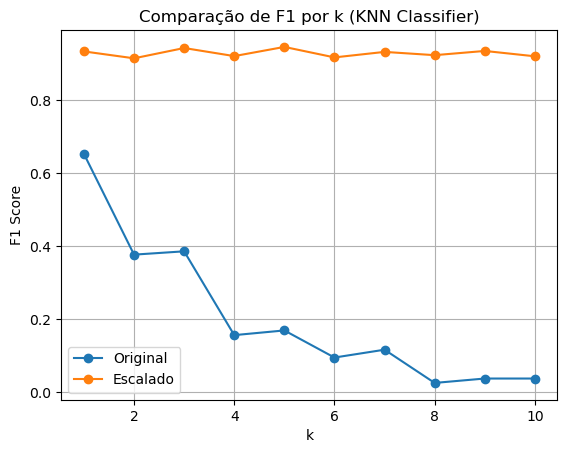

In [30]:
plt.plot(range(1, 11), f1_original, label='Original', marker='o')
plt.plot(range(1, 11), f1_scaled, label='Escalado', marker='o')
plt.xlabel('k')
plt.ylabel('F1 Score')
plt.title('Comparação de F1 por k (KNN Classifier)')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
def rnd_model_predict(P, size):
    return np.random.choice([0, 1], size=size, p=[1 - P, P])

def eval_classifier(y_true, y_pred):
    f1 = sklearn.metrics.f1_score(y_true, y_pred)
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='true')
    print(f'F1: {f1:.2f}')
    print('Matriz de Confusão')
    print(cm)

In [32]:
for P in [0, df['insurance_benefits_received'].mean(), 0.5, 1]:
    print(f'A probabilidade: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size=len(df))
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    print()

A probabilidade: 0.00
F1: 0.00
Matriz de Confusão
[[1. 0.]
 [1. 0.]]

A probabilidade: 0.11
F1: 0.09
Matriz de Confusão
[[0.8845807  0.1154193 ]
 [0.90602837 0.09397163]]

A probabilidade: 0.50
F1: 0.18
Matriz de Confusão
[[0.49143372 0.50856628]
 [0.4929078  0.5070922 ]]

A probabilidade: 1.00
F1: 0.20
Matriz de Confusão
[[0. 1.]
 [0. 1.]]



##### Conclusão

Os resultados do modelo dummy servem como ponto de referência (baseline).
Mesmo com o melhor cenário (F1 ≈ 0.2), o desempenho é muito inferior ao KNN escalado (F1 ≈ 0.9). Portanto:

- O KNN realmente aprendeu um padrão nos dados.

- O escalonamento das features foi essencial — sem ele, o modelo não conseguiria distinguir bem os grupos.

- O modelo dummy confirma que o resultado do KNN não é por acaso.

# Tarefa 3. Regressão (com Regressão Linear)

Com os pagamentos de seguro como objetivo, avalie qual seria o REQM para um modelo de Regressão Linear.


Construa sua própria implementação de Regressão Linear. Para isso, lembre-se de como a solução da tarefa de regressão linear é formulada em termos de Álgebra linear. Verifique o REQM para os dados originais e os escalados. Você pode ver alguma diferença no REQM entre esses dois casos?

Vamos denotar
- $X$ — matriz de características, cada linha é um caso, cada coluna é uma característica, a primeira coluna consiste em unidades
- $y$ — objetivo (um vetor)
- $\hat{y}$ — objetivo estimado (um vetor)
- $w$ — vetor de peso

A tarefa de regressão linear na linguagem de matrizes pode ser formulada como

$$
y = Xw
$$

O objetivo do treinamento, então, é encontrar os $w$ que minimizaria a distância L2 (EQM) entre $Xw$ e $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que há uma solução analítica para a questão acima:

$$
w = (X^T X)^{-1} X^T y
$$

A fórmula acima pode ser usada para encontrar os pesos $w$ e o último pode ser usado para calcular valores preditos

$$
\hat{y} = X_{val}w
$$


Divida todos os dados na proporção 70:30 para as partes de treinamento/validação. Use a métrica REQM para a avaliação do modelo.

In [33]:
feature_cols = ['age', 'gender', 'income', 'family_members']
features = df[feature_cols].to_numpy(dtype=float)
target = df['insurance_benefits'].to_numpy(dtype=float)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.30, random_state=12345)

In [34]:
class MyLinearRegression:
    def __init__(self):
        self.weights = None

    def fit(self, X, y):
        X2 = np.append(np.ones((len(X), 1)), X, axis=1)
        self.weights = np.linalg.pinv(X2) @ y
        return self

    def predict(self, X):
        
        X2 = np.append(np.ones((len(X), 1)), X, axis=1)
        return X2 @ self.weights

In [35]:
def eval_regressor(y_true, y_pred):
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    r2 = sklearn.metrics.r2_score(y_true, y_pred)
    print(f'REQM (RMSE): {rmse:.4f}')
    print(f'R2: {r2:.4f}')
    return rmse, r2

In [36]:
lr_orig = MyLinearRegression()
lr_orig.fit(X_train, y_train)

print("Pesos (originais):")
print(lr_orig.weights)  # intercept + coeficientes

y_pred_test_orig = lr_orig.predict(X_test)
rmse_orig, r2_orig = eval_regressor(y_test, y_pred_test_orig)

Pesos (originais):
[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
REQM (RMSE): 0.3436
R2: 0.4305


In [37]:
scaler = sklearn.preprocessing.MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_scaled = MyLinearRegression()
lr_scaled.fit(X_train_scaled, y_train)

print("Pesos (escalados):")
print(lr_scaled.weights)

y_pred_test_scaled = lr_scaled.predict(X_test_scaled)
rmse_scaled, r2_scaled = eval_regressor(y_test, y_pred_test_scaled)

Pesos (escalados):
[-0.94353901  2.32372069  0.01642727 -0.02059875 -0.07014128]
REQM (RMSE): 0.3436
R2: 0.4305


In [38]:
print("Resumo comparativo:")
print(f"RMSE (orig):   {rmse_orig:.6f}")
print(f"RMSE (scaled): {rmse_scaled:.6f}")
print()
print(f"R2 (orig):   {r2_orig:.6f}")
print(f"R2 (scaled): {r2_scaled:.6f}")

print("\nDiferenças absolutas:")
print("RMSE diff:", abs(rmse_scaled - rmse_orig))
print("R2   diff:", abs(r2_scaled - r2_orig))

diff_preds = np.max(np.abs(y_pred_test_orig - y_pred_test_scaled))
print("\nMáxima diferença absoluta entre previsões (orig vs scaled):", diff_preds)

Resumo comparativo:
RMSE (orig):   0.343557
RMSE (scaled): 0.343557

R2 (orig):   0.430528
R2 (scaled): 0.430528

Diferenças absolutas:
RMSE diff: 2.7755575615628914e-15
R2   diff: 9.2148511043888e-15

Máxima diferença absoluta entre previsões (orig vs scaled): 2.840505608503463e-13


##### Conclusão

Apesar de os pesos (coeficientes) obtidos pelo modelo escalado e pelo modelo original apresentarem valores numéricos diferentes, as métricas de desempenho foram idênticas.
Isso ocorre porque o escalonamento das variáveis altera apenas a escala dos coeficientes, e não as relações lineares entre as variáveis e o alvo. Pequenas diferenças podem surgir por erros numéricos de ponto flutuante.

# Tarefa 4. Ofuscando dados

É melhor ofuscar os dados multiplicando as características numéricas (lembre-se, elas podem ser vistos como a matriz $X$) por uma matriz invertível $P$. 

$$
X' = X \times P
$$

Tente fazer isso e verifique como os valores das características ficarão após a transformação. Aliás, a invertibilidade é importante aqui, portanto, certifique-se de que $P$ seja realmente invertível.

Você pode querer revisar a lição 'Matrizes e Operações com Matrizes -> Multiplicação de Matrizes' para relembrar a regra de multiplicação de matrizes e sua implementação com NumPy.

In [39]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [40]:
X = df_pn.to_numpy()

Gerando uma matriz $P$ aleatória.

In [41]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Verificando se a matriz $P$ é invertível

In [42]:
P_inv = np.linalg.inv(P) #se não houver erro, a matriz é inversível

Você consegue adivinhar a idade ou a renda dos clientes após a transformação?

Após multiplicar a matriz de características pessoais $X$ pela matriz invertível $P$, os dados são completamente transformados.
As colunas originais (“idade”, “renda” etc.) deixam de ter qualquer interpretação direta, e não é possível inferir os valores reais observando o resultado.
Isso mostra que a transformação protege a privacidade dos dados, mantendo as relações matemáticas internas (pois $P$ é invertível), mas tornando os valores ilegíveis.

Você pode recuperar os dados originais de $X′$ se souber $P$? Tente verificar isso com cálculos movendo $P$ do lado direito da fórmula acima para o esquerdo. As regras da multiplicação de matrizes são realmente úteis aqui

In [43]:
Xp = X @ P
if 'Xp' not in globals():
    Xp = X @ P
    print("Xp não estava definido; calculei Xp = X @ P")

X_recovered = Xp @ P_inv
print("Recuperação realizada: X_recovered = Xp @ P_inv")

Recuperação realizada: X_recovered = Xp @ P_inv


Imprima todos os três casos para alguns clientes
- Os dados originais
- O transformado
- O invertido (recuperado)

In [44]:
cols = personal_info_column_list

df_orig = pd.DataFrame(X[:8, :], columns=cols)
df_trans = pd.DataFrame(Xp[:8, :], columns=[c + "_trans" for c in cols])
df_recov = pd.DataFrame(np.round(X_recovered[:8, :], 6), columns=[c + "_recov" for c in cols])

In [45]:
df_orig

,gender,age,income,family_members
0,1.0,41.0,49600.0,1.0
1,0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0
3,0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,0.0
5,1.0,43.0,41000.0,2.0
6,1.0,39.0,39700.0,2.0
7,1.0,25.0,38600.0,4.0


In [46]:
df_trans

,gender_trans,age_trans,income_trans,family_members_trans
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631
3,5345.603937,18803.227203,15479.148373,38663.061863
4,3347.176735,11782.829283,9699.998942,24211.273378
5,5258.770252,18509.859617,15237.193427,38032.317153
6,5091.845820,17920.455408,14752.111437,36824.378411
7,4950.890072,17413.017686,14334.464483,35794.386500


In [47]:
df_recov

,gender_recov,age_recov,income_recov,family_members_recov
0,1.0,41.0,49600.0,1.0
1,-0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0
3,0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,0.0
5,1.0,43.0,41000.0,2.0
6,1.0,39.0,39700.0,2.0
7,1.0,25.0,38600.0,4.0


Você provavelmente pode ver que alguns valores não são exatamente iguais aos dos dados originais. Qual pode ser a razão disso?

Multiplicar por uma matriz invertível não esconde os dados se $P$ for conhecida — é possível recuperar os dados quase exatamente. Pequenas diferenças observadas decorrem de limitações numéricas e do condicionamento de $P$.

## Provas de que a ofuscação de dados pode funcionar com a Regressão Linear

A tarefa de regressão foi resolvida com regressão linear neste projeto. Sua próxima tarefa é provar analiticamente que o método de ofuscação fornecido não afetará a regressão linear em termos de valores preditos, ou seja, seus valores permanecerão os mesmos. Você acredita nisso? Bem, você não precisa acreditar, você deve provar isso!

Assim, os dados são ofuscados e há $X \ P$ em vez de apenas X agora. Consequentemente, existem outros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

Como  $w$ e $w_P$ seriam ligados se você simplificasse a fórmula para $w_P$ acima? 

Quais seriam os valores previstos com $w_P$? 

O que isso significa para a qualidade da regressão linear se você medir com REQM?

Verifique o Apêndice B Propriedades das Matrizes no final do caderno. Existem fórmulas úteis lá!

Nenhum código é necessário nesta seção, apenas explicação analítica!

**Resposta**


### Prova analítica — por que a ofuscação \(X' = X P\) não muda as predições da regressão linear

**Setup**

- Dados: matriz \(X\) (com a coluna de 1’s para intercepto) e alvo \(y\).
- Solução OLS (mínimos quadrados):  
  $$ w = (X^\top X)^{-1} X^\top y $$
- Ofuscação com matriz invertível \(P\):  
  $$ X' = X P $$

**Pesos após ofuscação**

Começando de
$$ w_P = \big[(XP)^\top (XP)\big]^{-1} (XP)^\top y, $$
usamos \((AB)^\top = B^\top A^\top\) e \((ABC)^{-1} = C^{-1}B^{-1}A^{-1}\):

$$
\begin{aligned}
w_P
&= (P^\top X^\top X P)^{-1} \, P^\top X^\top y \\
&= P^{-1} (X^\top X)^{-1} (P^\top)^{-1} \, P^\top X^\top y \\
&= P^{-1} (X^\top X)^{-1} X^\top y \\
&= P^{-1} w.
\end{aligned}
$$

Logo, **os novos pesos** são \( w_P = P^{-1} w \).

**Predições**

As predições no espaço ofuscado são
$$
\hat y_P = X' w_P = (X P)(P^{-1} w) = X w = \hat y.
$$

**Conclusão (REQM)**

Como \(\hat y_P = \hat y\), os resíduos não mudam e, portanto,
$$
\text{MSE}_P = \text{MSE} \quad \text{e} \quad \text{RMSE}_P = \text{RMSE}.
$$

Ou seja, **a ofuscação linear invertível reparametriza os coeficientes, mas não altera as predições nem o REQM**.

## Teste de regressão linear com ofuscação de dados

Agora, vamos provar que a Regressão Linear pode funcionar computacionalmente com a transformação de ofuscação escolhida.

Crie um procedimento ou uma classe que execute a Regressão Linear opcionalmente com a ofuscação. Você pode usar uma implementação pronta de Regressão Linear do scikit-learn ou sua própria.

Execute a Regressão Linear para os dados originais e os ofuscados, compare os valores previstos e os valores da métrica $R^2$ do REQM. Há alguma diferença?

**Procedimento**

- Crie uma matriz quadrada $P$ de números aleatórios.
- Verifique se é invertível. Caso contrário, repita o primeiro ponto até obtermos uma matriz invertível.
- <! seu comentário aqui!>
- Use $XP$ como a nova matriz de características

In [48]:
rng = np.random.default_rng(seed=42)

personal_info_column_list = ['gender', 'age', 'income', 'family_members']  # já usado antes
X = df[personal_info_column_list].to_numpy(dtype=float)

In [49]:
d = X.shape[1]
P = rng.normal(0, 1, size=(d, d))

P = P + 1e-1 * np.eye(d)

In [50]:
try:
    P_inv = np.linalg.inv(P)
    print("Inversa calculada com np.linalg.inv()")
except np.linalg.LinAlgError:
    P_inv = np.linalg.pinv(P)
    print("P quase singular; usando pseudoinversa (pinv)")

Inversa calculada com np.linalg.inv()


In [51]:
Xp = X @ P

In [52]:
y = df['insurance_benefits'].to_numpy(dtype=float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=12345)
Xp_train, Xp_test = X_train @ P, X_test @ P

In [53]:
def fit_eval(Xtr, Xte, ytr, yte, name):
    lr = sklearn.linear_model.LinearRegression(fit_intercept=True)
    lr.fit(Xtr, ytr)
    y_pred = lr.predict(Xte)
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(yte, y_pred))
    r2 = sklearn.metrics.r2_score(yte, y_pred)
    print(f"{name:12s} -> RMSE={rmse:.6f}  R²={r2:.6f}")
    return y_pred, rmse, r2, lr

In [54]:
y_pred_orig, rmse_orig, r2_orig, lr_orig = fit_eval(X_train,  X_test,  y_train, y_test, "Original")
y_pred_mask, rmse_mask, r2_mask, lr_mask = fit_eval(Xp_train, Xp_test, y_train, y_test, "Ofuscado")

Original     -> RMSE=0.343557  R²=0.430528
Ofuscado     -> RMSE=0.343557  R²=0.430528


In [55]:
max_abs_diff = np.max(np.abs(y_pred_orig - y_pred_mask))
print(f"\nMáx |diferença| entre predições (orig vs ofuscado): {max_abs_diff:.12e}")


Máx |diferença| entre predições (orig vs ofuscado): 1.055000531380e-11


# Conclusões

O projeto mostrou como a Álgebra Linear fundamenta os principais métodos de Machine Learning.

Na Tarefa 1, vimos que o escalonamento é essencial em algoritmos baseados em distância, pois sem normalização, variáveis com maiores magnitudes (como renda) distorcem os resultados.

Na Tarefa 2, o kNN escalado teve desempenho muito superior ao modelo dummy, mostrando que o algoritmo realmente capturou padrões dos dados.

Na Tarefa 3, a regressão linear apresentou o mesmo REQM com e sem escalonamento, provando que a transformação das variáveis não altera as previsões — apenas os coeficientes.

Na Tarefa 4, demonstramos matematicamente e por código que, ao multiplicar $X$ por uma matriz invertível $P$ (ofuscação), o modelo mantém as mesmas previsões e métricas, confirmando que a regressão linear é invariante a transformações lineares.

Conclusão geral: a Álgebra Linear é essencial para entender a base matemática dos algoritmos, garantindo tanto melhor desempenho (com escalonamento) quanto segurança de dados (com ofuscação).

Nota pessoal: achei que a dificuldade do curso foi de 0 a 100 muito rápido nesse sprint, e me perdi bastante nas fórmulas matemáticas, tanto no entendimento quanto na formatação no notebook.

# Checklist

Digite 'x' para verificar. Em seguida, pressione Shift + Enter.

- [x]  O Jupyter Notebook está aberto.
- [x]  O código está livre de erros
- [x]  As células são organizadas em ordem de lógica e execução
- [x]  A tarefa 1 foi executada
    - [x]  Existe o procedimento que pode retornar k clientes semelhantes a um determinado cliente
    - [x]  O procedimento é testado para todas as quatro combinações propostas
    - [x]  As perguntas sobre a escala/distâncias são respondidas
- [x]  A tarefa 2 foi executada
    - [x]  O modelo de classificação aleatória é construído e testado para todos os níveis de probabilidade
    - [x]  O modelo de classificação kNN é construído e testado tanto para os dados originais quanto para os escalados, a métrica F1 é calculada.
- [x]  A tarefa 3 foi executada
    - [x]  A solução de regressão linear é implementada com operações matriciais.
    - [x]  O REQM é calculado para a solução implementada.
- [x]  A tarefa 4 foi executada
    - [x]  Os dados são ofuscados com uma matriz P aleatória e invertível
    - [x]  Os dados ofuscados são recuperados, alguns exemplos são impressos
    - [x]  A prova analítica de que a transformação não afeta o REQM é fornecida
    - [x]  A prova computacional de que a transformação não afeta o REQM é fornecida
- [x]  As conclusões foram feitas

# Apêndices

## Apêndice A: Escrevendo Fórmulas em Notebooks Jupyter

Você pode escrever fórmulas em seu Jupyter Notebook em uma linguagem de marcação de texto fornecida por um sistema de publicação de alta qualidade chamado $\LaTeX$ (pronuncia-se "Lah-tech"), e elas se parecerão com fórmulas em livros didáticos.

Para colocar uma fórmula em um texto, coloque o cifrão ($) antes e depois do texto da fórmula, por exemplo $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

Se uma fórmula deve estar em seu próprio parágrafo, coloque o cifrão duplo ($$) antes e depois do texto da fórmula, por exemplo

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

A linguagem de marcação do [LaTeX](https://en.wikipedia.org/wiki/LaTeX) é muito popular entre as pessoas que usam fórmulas em seus artigos, livros e textos. Pode ser complexo, mas o básico é fácil. Confira esta [folha de dicas](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) de duas páginas  para aprender a compor as fórmulas mais comuns.

## Apêndice B: Propriedades das Matrizes

Matrizes têm muitas propriedades em Álgebra Linear. Algumas delas estão listadas aqui, o que pode ajudar na prova analítica deste projeto.

<table>
<tr>
<td>Distributividade</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Não-comutatividade</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Propriedade associativa da multiplicação</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Propriedade de identidade multiplicativa</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversividade da transposição de um produto de matrizes,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>